<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/ew_distributions_AHG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install netCDF4
import xarray as xr
# from netCDF4 import Dataset
import numpy as np
import pandas as pd
import geopandas as gpd
from google.colab import drive
from matplotlib import pyplot as plt
import datetime

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cb_centerlines = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/centerlines/s2_platte_centerlines_4326.shp').to_crs(3857)

In [5]:
merit_centerlines = gpd.read_file('/content/drive/MyDrive/MERIT/riv_pfaf_7_MERIT_Hydro_v07_Basins_v01_bugfix1.shp').to_crs(3857)

In [6]:
ew_points = gpd.read_file('/content/drive/MyDrive/platte_pts_10000m.shp')[['iindex', 'geometry']].to_crs(3857)
circles = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/all_sites/buffs_3x_width_20250903.shp')[['iindex', 'riv_length']]
ew_points = pd.merge(ew_points, circles[['iindex', 'riv_length']])
ew_points = gpd.sjoin_nearest(ew_points, cb_centerlines[['NewSO', 'geometry']], distance_col='join_dist')\
    .groupby('iindex').first()\
    .drop('index_right', axis=1, inplace=False)

ew_points = gpd.GeoDataFrame(ew_points, geometry=ew_points.geometry, crs=3857)
ew_points = gpd.sjoin_nearest(ew_points, merit_centerlines[['COMID', 'geometry']]).drop('index_right', axis=1, inplace=False)

ew_points

,geometry,riv_length,NewSO,join_dist,COMID
iindex,,,,,
155,POINT (-11243564.788 5219812.048),92.159279,7,8.532072,74023843
692,POINT (-11362544.764 5056639.618),555.581273,11,7.753984,74029263
932,POINT (-10684605.158 5020117.423),2146.011934,12,5.101279,74029086
1082,POINT (-11013074.932 5235748.934),96.592695,7,0.621279,74023735
1675,POINT (-11007265.243 5232128.286),76.191304,8,3.852376,74023725
...,...,...,...,...,...
255389,POINT (-10896185.233 5035750.772),1820.697006,12,9.025301,74029122
255765,POINT (-10927944.929 5054217.028),1713.045801,10,5.744229,74036331
256070,POINT (-10933005.076 5052061.849),1258.409978,10,6.801573,74029261


In [7]:
Qarray = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2024.nc')

In [8]:
Qarray.head()

<xarray.Dataset> Size: 308B
Dimensions:   (time: 5, rivid: 5, nerr: 3)
Coordinates:
  * rivid     (rivid) int32 20B 71000001 71000002 71000003 71000004 71000005
  * time      (time) datetime64[ns] 40B 2024-01-01 2024-01-02 ... 2024-01-05
    lon       (rivid) float64 40B ...
    lat       (rivid) float64 40B ...
Dimensions without coordinates: nerr
Data variables:
    Qout      (time, rivid) float32 100B ...
    Qout_err  (nerr, rivid) float32 60B ...
    crs       float64 8B ...
Attributes:
    model:    Grid-scale LSTM-RAPID daily version, developed by Yuan Yang, yu...
    NCO:      netCDF Operators version 5.1.9 (Homepage = http://nco.sf.net, C...
    version:  version 2.0
    history:  Fri Mar 28 21:54:46 2025: ncatted -a history,global,d,, GRADES_...

In [31]:
Qarray['Qout'].sel(time=datetime.date(2024, 1, 1), rivid=71000001, method='nearest').values

array(0.00071544, dtype=float32)

In [ ]:
Q2024_df = Q2024.to_dataframe()

In [ ]:
COMID = Qid.variables['rivid'][:]

In [ ]:
t = Qid.variables['time'][:]

In [ ]:
COMID_mask = np.isin(COMID, ew_points.COMID)

plt.imshow(Q2024[0:365, 0:100])

In [ ]:
print(COMID_mask.tolist())

In [ ]:
tid = 74031391

tQ = Q2024[:, COMID == tid]
plt.plot(tQ)

In [39]:
years = [2024]
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
df_list = []

for y in years:
    for m in months:
        df_list.append(pd.read_csv(f'/content/drive/MyDrive/effwidth_results/all_sites/effwidths_{m}_{y}_20250928.csv'))

widths = pd.concat(df_list)

widths['date'] = widths.apply(lambda x: datetime.date(int(x['img_id'][10:14]), int(x['img_id'][14:16]), int(x['img_id'][16:18])), axis=1)
widths['date'] = pd.to_datetime(widths.date)

widths = pd.merge(widths, ew_points, on='iindex', how='left')

widths

,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,date,geometry,riv_length,NewSO,join_dist,COMID
0,0,S2A_13TGF_20240103_0_L2A,9803,308,308,79,0,308,0,58,9,2024-01-03,POINT (-11408584.956 5002072.656),216.883515,11,5.595291,74029423
1,1,S2A_13TGF_20240103_0_L2A,13320,765,765,171,0,743,0,90,16,2024-01-03,POINT (-11398675.129 5005766.481),347.622278,11,1.232603,74029423
2,2,S2A_13TGF_20240103_0_L2A,13696,758,758,154,0,200,0,90,8,2024-01-03,POINT (-11402435.244 5004680.728),339.202685,11,5.287914,74029423
3,3,S2A_13TGF_20240103_0_L2A,7591,1455,1455,260,0,838,0,124,9,2024-01-03,POINT (-11418684.899 5000034.786),469.490756,11,5.024024,74029425
4,4,S2A_13TGF_20240103_0_L2A,36643,1456,1456,281,55,864,0,124,10,2024-01-03,POINT (-11368854.808 5059048.937),485.916837,11,12.464640,74029266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33108,1654,S2B_13TDH_20241206_0_L2A,62576,1877,1877,83,0,0,0,140,0,2024-12-06,POINT (-11722054.972 5259989.668),549.088806,11,6.139974,74022673
33109,1655,S2B_13TDH_20241206_0_L2A,61240,2076,2076,234,0,0,0,148,10,2024-12-06,POINT (-11698714.956 5253777.263),301.856390,11,0.486193,74022669
33110,1656,S2B_13TDH_20241206_0_L2A,54370,2372,2372,209,0,0,0,158,8,2024-12-06,POINT (-11700984.924 5255435.393),594.648790,11,5.584516,74022669
33111,1657,S2B_13TDH_20241206_0_L2A,106191,3151,3151,268,0,0,0,182,9,2024-12-06,POINT (-11732255.185 5276879.763),718.961151,11,1.274648,74022679


In [41]:
widths['sat_width_m'] = widths.n_river * 100 / widths.riv_length
widths['fraction_cloud'] = widths.n_cloud / widths.n_pixels
widths['fraction_snow'] = widths.n_snow / widths.n_pixels
widths['fraction_edgeriver'] = widths.n_edgeriver / widths.n_edge

widths_filtered = widths.copy()
widths_filtered = widths_filtered.loc[widths_filtered.fraction_cloud < 0.2]
widths_filtered = widths_filtered.loc[widths_filtered.fraction_snow < 0.2]
widths_filtered = widths_filtered.loc[widths_filtered.n_edge < widths_filtered.n_river]

In [47]:
widths_filtered['GRADES'] = widths_filtered.apply(lambda x: Qarray['Qout'].sel(time=(x['date']), rivid=x['COMID']).values, axis=1)

In [48]:
allos = set(widths_filtered.NewSO.tolist())
print(allos)

{6, 7, 8, 9, 10, 11, 12}


In [70]:
widths_filtered

,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,...,geometry,riv_length,NewSO,join_dist,COMID,sat_width_m,fraction_cloud,fraction_snow,fraction_edgeriver,GRADES
12,12,S2A_13TGF_20240103_0_L2A,158552,293,293,76,0,0,0,57,...,POINT (-11299214.991 5039258.247),210.987410,11,10.468011,74029238,36.021107,0.0,0.0,0.122807,1.821875
32,32,S2A_13TEG_20240103_0_L2A,99883,310,310,61,0,0,0,59,...,POINT (-11578154.987 5155822.37),224.360542,11,0.145526,74022645,27.188381,0.0,0.0,0.118644,0.078780584
37,37,S2A_13TEG_20240103_0_L2A,86992,759,759,94,0,0,0,91,...,POINT (-11549074.777 5146654.082),309.232494,11,2.620970,74022532,30.397840,0.0,0.0,0.076923,12.746226
39,39,S2A_13TEG_20240103_0_L2A,78407,944,944,138,0,0,0,100,...,POINT (-11603455.227 5171220.092),376.697146,11,7.261784,74022647,36.634204,0.0,0.0,0.060000,2.2762008
40,40,S2A_13TEG_20240103_0_L2A,85825,1077,1077,129,0,0,0,108,...,POINT (-11569835.081 5151882.397),483.257240,11,1.441665,74022533,26.693858,0.0,0.0,0.083333,38.17704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33107,1653,S2B_13TDH_20241206_0_L2A,57706,1882,1882,243,0,0,0,141,...,POINT (-11707244.834 5258452.885),529.108201,11,2.985760,74022671,45.926334,0.0,0.0,0.070922,2.4943118
33109,1655,S2B_13TDH_20241206_0_L2A,61240,2076,2076,234,0,0,0,148,...,POINT (-11698714.956 5253777.263),301.856390,11,0.486193,74022669,77.520307,0.0,0.0,0.067568,0.11709142
33110,1656,S2B_13TDH_20241206_0_L2A,54370,2372,2372,209,0,0,0,158,...,POINT (-11700984.924 5255435.393),594.648790,11,5.584516,74022669,35.146796,0.0,0.0,0.050633,0.11709142
33111,1657,S2B_13TDH_20241206_0_L2A,106191,3151,3151,268,0,0,0,182,...,POINT (-11732255.185 5276879.763),718.961151,11,1.274648,74022679,37.276006,0.0,0.0,0.049451,0.38742828


In [64]:
medians = widths_filtered.groupby('iindex')['sat_width_m'].agg('median')

In [57]:
from scipy.stats import gaussian_kde

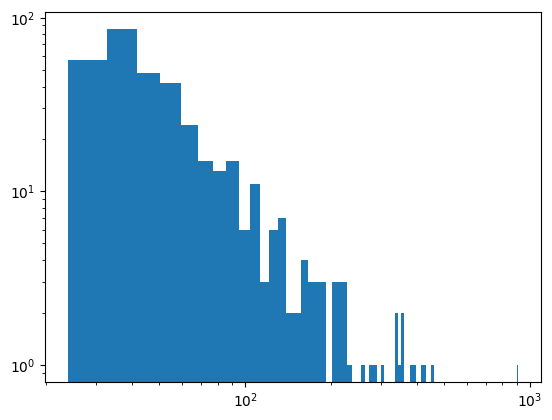

In [68]:
kde = gaussian_kde(medians)
x_kde = np.linspace(min(medians), max(medians), 100)
kde_values = kde(x_kde)


fig, ax = plt.subplots()
# ax.plot(x_kde, kde_values)
ax.hist(medians, bins=100)
ax.set_xscale('log')
ax.set_yscale('log')

## sanity check... aggregating across stream orders looks like a pareto!!!!!!

In [71]:
ordermeds = widths_filtered.groupby(['iindex', 'NewSO'])['sat_width_m'].agg('median')

,,sat_width_m
iindex,NewSO,
692,11,92.335726
932,12,235.343519
1082,7,31.575887
1877,7,41.712206
3018,8,31.602672
...,...,...
254274,10,84.373380
255389,12,273.521623
255765,10,204.985763
